-----------
Initializing structure...
time for choose_chunkdivision = 1.50204e-05 s
Working in 2D dimensions.
Computational cell is 13 x 0.02 x 0 with resolution 50
     block, center = (-5.6,0,0)
          size (1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-5.05,0,0)
          size (0.1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.9,10.9,10.9)
     block, center = (0,0,0)
          size (10,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
     block, center = (5.05,0,0)
          size (0.1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.9,10.9,10.9)
     block, center = (5.6,0,0)
          size (1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1

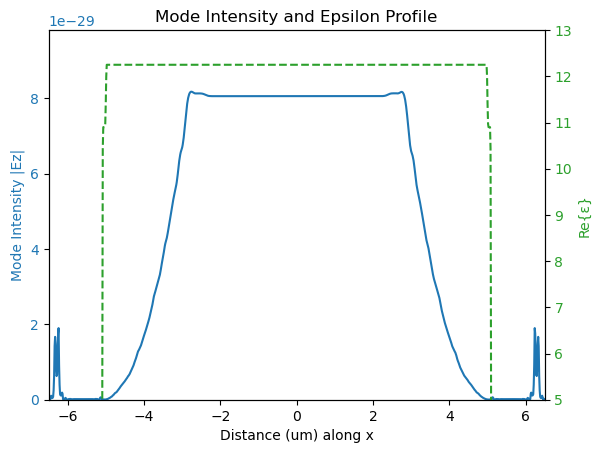

run 1 finished at t = 30.0 (3000 timesteps)


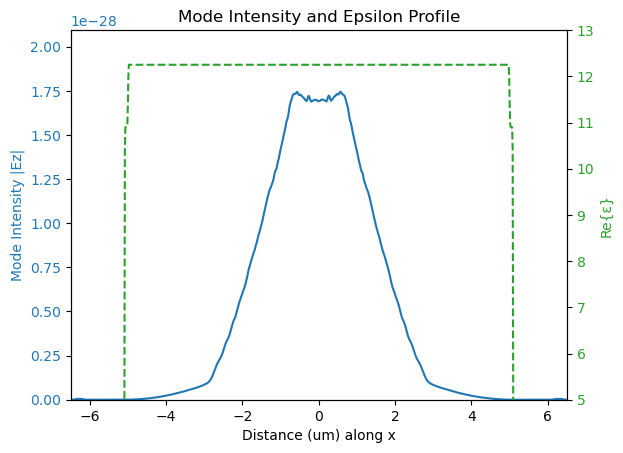

run 2 finished at t = 60.0 (6000 timesteps)


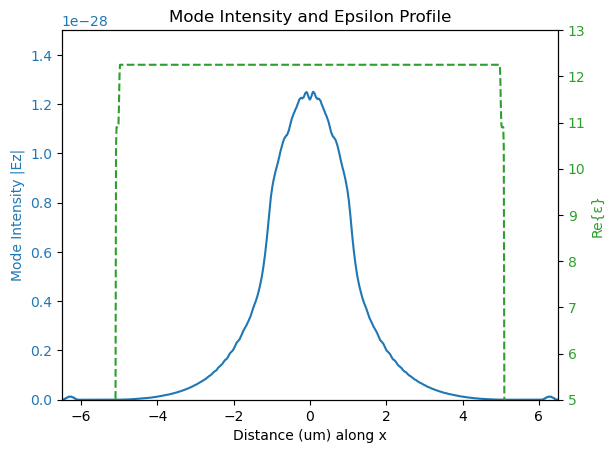

run 3 finished at t = 100.0 (10000 timesteps)


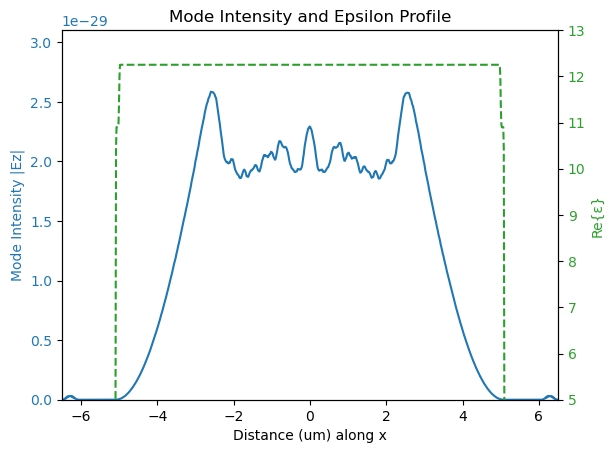

run 4 finished at t = 150.0 (15000 timesteps)


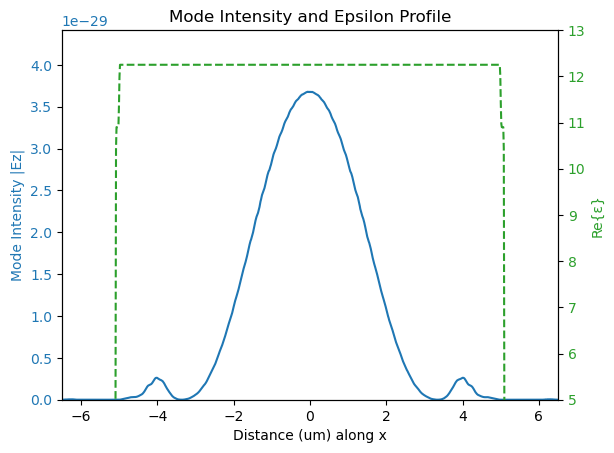

run 5 finished at t = 210.0 (21000 timesteps)


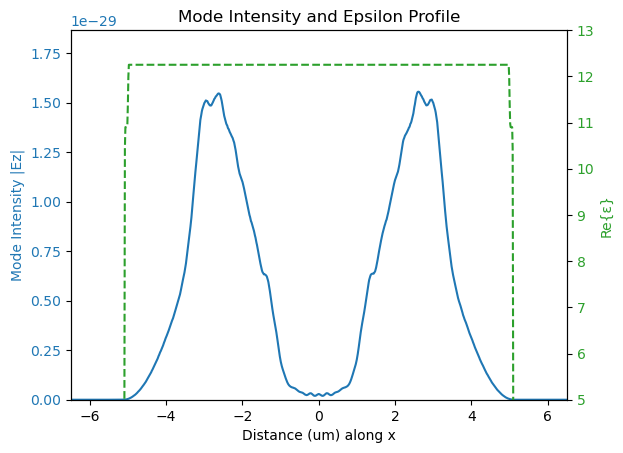

run 6 finished at t = 280.0 (28000 timesteps)


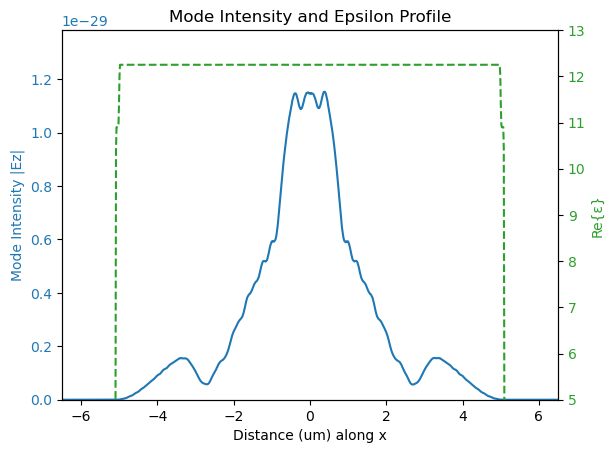

run 7 finished at t = 360.0 (36000 timesteps)


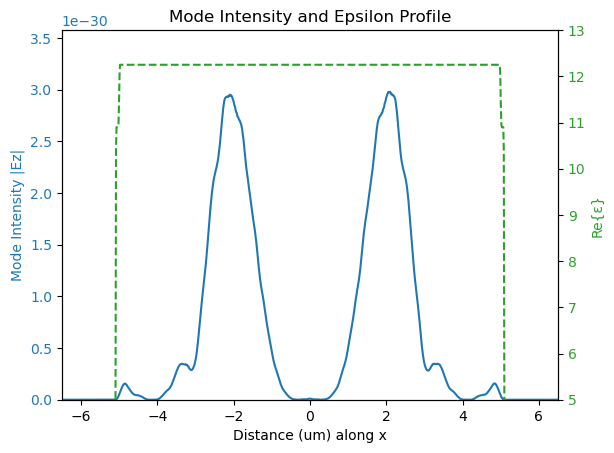

run 8 finished at t = 450.0 (45000 timesteps)


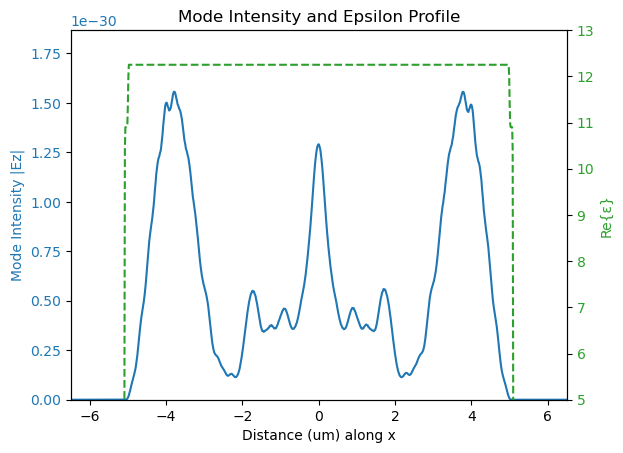

In [2]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au

# basic setup (1 μm)
resolution = 50
sx = 13
sy = 0
sz = 5
cell = mp.Vector3(sx, sy, sz)
# Perfectly Matched Layer if THz , set PML to 1
pml_layers = [mp.PML(1)]
# thickness of different layers（1 μm）
Au_thickness = 1
n_GaAs_thickness = 0.1
light_GaAs_thickness = 10

###---------------------------------------------------------------basic config-------------------------------------------------------------------###
# Au = mp.Medium(
#     epsilon=1.0,
#     E_susceptibilities=[
#         mp.DrudeSusceptibility(
#             frequency=5.0,
#             gamma=0.5,    
#             sigma=1.0)])

# N = 5e18 /cm3
# n_GaAs = mp.Medium(epsilon=12.25)
n_GaAs = mp.Medium(
    epsilon=10.9,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=1.62, 
                               gamma=0.033, 
                               sigma=1.0)])


# N = 5e15 /cm3
# light_GaAs = mp.Medium(epsilon=12.25)
light_GaAs = mp.Medium(
    epsilon=12.25,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=0.0513, 
                               gamma=0.0033, 
                               sigma=1.0)])

# N = 1e18 /cm3
nplus_GaAs = mp.Medium(
    epsilon=10.9,  
    E_susceptibilities=[
        mp.DrudeSusceptibility(
            frequency=0.7252,   # Plasma resonant frequency
            gamma=0.0333,       # damping constant
            sigma=1.0           # conductivity
        )
    ]
)

# Set up for source frequency 
frequency = 5e12 # 5THz
# Set up for detector 's observe range
observe_range = 0.1

###-------------------------------------------------------------geometry---------------------------------------------------------------------###
def add_layer(thickness, material):
    global x0
    center_x = x0 + 0.5 * thickness
    geometry.append(mp.Block(size=mp.Vector3(thickness,mp.inf,mp.inf),center=mp.Vector3(center_x, 0, 0),material=material))
    x0 += thickness
# define the basic height of layers



# Construct layers
geometry = []
# x0 = -0.5 * (Au_thickness + n_GaAs_thickness + light_GaAs_thickness + 2 + Au_thickness)
# add_layer(Au_thickness, nplus_GaAs)
# add_layer(2, n_GaAs)

x0 = -0.5 * (Au_thickness + n_GaAs_thickness + light_GaAs_thickness + n_GaAs_thickness + Au_thickness)
add_layer(Au_thickness, Au)
add_layer(n_GaAs_thickness, n_GaAs)
add_layer(light_GaAs_thickness,light_GaAs)
add_layer(n_GaAs_thickness, n_GaAs)
add_layer(Au_thickness, Au)

###-----------------------------------------------------------source------------------------------------------------------------------------###
# Source
sources = [mp.Source(
            src=mp.ContinuousSource(frequency=frequency,fwidth=0.1*frequency,start_time=0,
            end_time=1e1),component=mp.Ez,center=mp.Vector3(0,0,-sz/2),size = mp.Vector3(sx,0,0))]

# Simulation setup
sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    # boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    dimensions=2)

# sim.plot2D()
for i in range (10,100,10):
    sim.run(until=i)
    ###-------------------------------------------------------------Plot--------------------------------------------------------------------###

    # ez on x axis
    x = np.linspace(-sx/2, sx/2, 1000)
    eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0)) for xi in x])
    ez_data = np.array([sim.get_field_point(mp.Ez, mp.Vector3(xi))**2/2 for xi in x])

    # === plot === #
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ez|', color=color)
    ax1.plot(x, ez_data, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim(-sx/2,sx/2)
    ax1.set_ylim(0, np.max(ez_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 13)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
